In [64]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
from itertools import count

os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
set_seed(42)

In [65]:
def f(x):
    pi = torch.pi
    return ((0.1*pi)**2 * torch.sin(0.1*pi*x) +
            (pi)**2 * 0.2 * torch.sin(pi*x) +
            (100/3*pi)**2 * 0.4 * torch.sin(100/3*pi*x) +
            (200/3*pi)**2 * 0.6 * torch.sin(200/3*pi*x) +
            (100*pi)**2 * torch.sin(100*pi*x))
def u(x):
    return torch.sin(0.1 * torch.pi * x) + \
              0.2 * torch.sin(torch.pi * x) + \
                0.4 * torch.sin(100/3 * torch.pi * x) + \
                    0.6 * torch.sin(200/3 * torch.pi * x) + \
                        torch.sin(100 * torch.pi * x)

In [66]:
class MultiScaleFourierLayer(nn.Module):
    def __init__(self, input_dim, base_feature_dim, num_scales,sigma=1.0,beta=0.1):
        super().__init__()
        self.input_dim=input_dim
        self.base_feature_dim=base_feature_dim
        self.num_scales=num_scales
        self.M = base_feature_dim * (num_scales + 1)
        base_freqs = torch.randn(self.base_feature_dim, input_dim) * np.pow(sigma,-1)
        all_freqs=[]
        for feature in base_freqs:
            for k in range(0,num_scales+1):
                scale=2.0**k
                all_freqs.append(scale*feature)
        
        omega = torch.stack(all_freqs, dim=0)

        self.register_buffer('omega',omega.reshape(-1,input_dim))
        self.total_feature_dim=self.omega.shape[0]
        print(f"Total feature dim={self.total_feature_dim}. All Fourier feature frequencies:\n{self.omega.detach().cpu().numpy().flatten()}")
        omega_np = self.omega.detach().cpu().numpy() # 形状: (M, input_dim)
        freq_magnitude = np.linalg.norm(omega_np, axis=1)
        plt.figure(figsize=(10, 6))
        plt.plot(figsize=(10, 6))
        plt.hist(freq_magnitude, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        plt.title(f'Frequency Magnitude Distribution\nTotal Dim: {self.total_feature_dim}')
        plt.xlabel('Frequency Magnitude')
        plt.ylabel('Count')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        phases=torch.rand(self.total_feature_dim)*2.0*np.pi 
        self.register_buffer('phases',phases)
        self.raw_beta=nn.Parameter(torch.log(torch.tensor(beta)))
        self.beta=nn.functional.softplus(self.raw_beta)
    def forward(self, x):
        amplitude=torch.tensor(torch.exp(- self.beta * torch.norm(self.omega,dim=1)),device=x.device)
        self.scale=torch.sqrt(torch.tensor(1.0/self.total_feature_dim))
        proj = torch.matmul(x, self.omega.T) + self.phases
        features = torch.cos(proj)
        features = features * self.scale * amplitude
        return features

In [ ]:
class MLP_Network(nn.Module):
    def __init__(self,num_layers=4,width=32):
        super().__init__()
        self.device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
        layers = []
        layers.append(nn.Linear(1, width))
        for _ in range(num_layers - 2):
            layers.append(nn.Tanh())
            layers.append(nn.Linear(width, width))
        layers.append(nn.Linear(width, 1))
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

class NN_CA_Network(nn.Module):
    def __init__(self, input_dim=1, base_feature_dim=64, num_scales=3,
                 d_q=64, num_layers=4, num_heads=4, sigma=0.5, beta_init=0.001):
        super().__init__()
        self.device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
        self.rff = MultiScaleFourierLayer(input_dim, base_feature_dim, num_scales, sigma, beta_init).to(self.device)
        M = self.rff.M
        self.d_q = d_q
        assert M % d_q == 0
        self.N_tok = M // d_q

        # 初始 Q^(0) 来自原始输入 x，而非φ(x)
        self.initial_fc = nn.Sequential(
            nn.Linear(input_dim, d_q),
            nn.ReLU()
        ).to(self.device)
        # 共享相同的CA架构
        self.ca_blocks = CrossAttentionResidualBlock(d_q, num_layers, num_heads)
        self.output_layer = nn.Linear(d_q, 1).to(self.device)

    def forward(self, x):
        proj = torch.matmul(x, self.rff.omega.T) + self.rff.phases.unsqueeze(0)  # (B, M_post*d_q)
        scale = torch.sqrt(torch.tensor(1.0 / (self.rff.M * self.d_q), device=x.device))
        phi = torch.cos(proj) * scale
        H = phi.view(x.shape[0], self.N_tok, self.d_q)
        Q = self.initial_fc(x)  # (batch, d_q)
        Q_L = self.ca_blocks(Q, H)        
        return self.output_layer(Q_L)
    
class CrossAttentionResidualBlock(nn.Module):
    def __init__(self, d_q, num_layers, num_heads):
        super().__init__()
        assert d_q % num_heads == 0, "d_q must be divisible by num_heads"
        self.d_q = d_q
        self.num_layers = num_layers
        self.cross_attn = nn.ModuleList([
            nn.MultiheadAttention(
                embed_dim=d_q,
                num_heads=num_heads,
                dropout=0.0,
                batch_first=True,  
                bias=False
            ) for _ in range(num_layers)
        ])
        
        self.ln1 = nn.ModuleList([nn.LayerNorm(d_q) for _ in range(num_layers)])
        self.ln2 = nn.ModuleList([nn.LayerNorm(d_q) for _ in range(num_layers)])
        
        self.ffns = nn.ModuleList([
            nn.Sequential(nn.Linear(d_q, d_q), nn.ReLU())
            for _ in range(num_layers)
        ])
    def forward(self, Q, H):
        """
        Args:
            Q: (batch, d_q) 或 (batch, 1, d_q) - Query tokens
            H: (batch, N_tokens, d_q) - Key/Value tokens (RFF features)
        """
        if Q.dim() == 2:
            Q = Q.unsqueeze(1)  # (batch, 1, d_q)
        
        for i in range(self.num_layers):
            # 内置 Cross Attention：Q 作为 query，H 作为 key/value
            # 自动完成：线性投影 → 多头分割 → 缩放 → Softmax → 拼接 → 输出投影
            attn_out, _ = self.cross_attn[i](
                query=Q,           # (batch, 1, d_q)
                key=H,             # (batch, N, d_q)  
                value=H,           # (batch, N, d_q)
                need_weights=False
            )
            
            Q = Q + attn_out
            Q = self.ln1[i](Q)
            
            ffn_out = self.ffns[i](Q.squeeze(1)).unsqueeze(1)
            Q = Q + ffn_out
            Q = self.ln2[i](Q)
        
        return Q.squeeze(1)

class OneDimPoissonFunc(nn.Module):
    """
    神经网络求解器的抽象类
    """
    def __init__(self,batch_size=10000,alpha=None):
        super().__init__()
        self.alpha=alpha
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.record_steps=250
        self.lb = -1.0
        self.ub = 1.0
        self.boundary_x = torch.tensor([[-1.0], [1.0]], device=self.device)
        self.boundary_u = torch.tensor([[u(torch.tensor(-1.0))], [u(torch.tensor(1.0))]],device=self.device)
        self.batch_size = batch_size
        self.x_eval = torch.linspace(self.lb, self.ub, 2048).reshape(-1, 1).to(self.device) 
        self.u_eval = u(self.x_eval).detach().cpu().numpy()
        self.lb = torch.tensor(self.lb).to(self.device)
        self.ub = torch.tensor(self.ub).to(self.device)
        self.x_f = torch.linspace(self.lb, self.ub, self.batch_size).view(-1, 1).to(self.device).requires_grad_()
        #----------------------------------------------------------------------------------
        self.u_h=NN_CA_Network(input_dim=1, base_feature_dim=2048, num_scales=0,
                          d_q=64, num_layers=4, num_heads=4, sigma=0.005).to(self.device)
        #----------------------------------------------------------------------------------
        self.u_l=MLP_Network(num_layers=5,width=64).to(self.device)
        self.alpha_para = nn.Parameter(torch.tensor(-1.0,device=self.device))
        self.optimizer_h = torch.optim.AdamW([
            {
                'params': self.u_h.parameters(),
                'lr': 1e-2,
                "weight_decay": 1e-4
            }
        ])
        self.optimizer_l = torch.optim.Adam([
            {
                'params': self.u_l.parameters(),
                'lr': 1e-2,
            }
        ])
        self.optimizer_alpha = torch.optim.Adam([self.alpha_para], lr=1e-3) 
        self.lam = 1e3
        self.history = {'alpha': [], 'loss': [], 'error': []}
        self._alpha_counter = count()  # 作为实例属性存储
        self.cached_alpha = 1.0  # 用于存储上一次计算的 alpha 值
    def net_u(self, x):
        return self.get_alpha() * self.u_l(x) + self.u_h(x)

    def get_alpha(self):
        """mode 取 0, 1, "opt" 或者 learnable """
        if self.alpha == 0:
            return 0.0
        if self.alpha == 1:
            return 1.0
        if self.alpha == "opt":
            if next(self._alpha_counter) % 10 != 0:  # 原为 self.get_alpha.counter
                return self.cached_alpha
            x_r = torch.linspace(self.lb, self.ub, 512).view(-1, 1).to(self.device).requires_grad_()
            x_b = self.boundary_x
            N_uh = self.diff_operator(x_r, self.u_h).detach()  # N[u_h] = -u_h''
            N_ul = self.diff_operator(x_r, self.u_l).detach()  # N[u_l] = -u_l''
            with torch.no_grad():
                f_xr = f(x_r)
                numerator = torch.mean((N_uh - f_xr) * N_ul) + self.lam * torch.mean((self.u_h(x_b) - self.boundary_u) * self.u_l(x_b))
                u_l_boundary = self.u_l(x_b)
                denominator = torch.mean(N_ul**2) + self.lam * torch.mean(u_l_boundary**2)
            if abs(denominator.item()) < 1e-10:
                return 0.0
            alpha_value = - (numerator / denominator).item()
            self.cached_alpha = alpha_value
            return alpha_value
        
        if self.alpha =="learnable":
            return self.alpha_para
            
    def diff_operator(self, x, model):
        u = model(x)  
        h = (x[1, 0] - x[0, 0]).item()
        u_xx = torch.zeros_like(u)
        if u.shape[0] > 2:
            u_xx[1:-1,:] = (u[:-2,:] - 2 * u[1:-1,:] + u[2:,:]) / (h ** 2)
        if u.shape[0] >= 4:
            u_xx[0,:] = (2 * u[0,:] - 5 * u[1,:] + 4 * u[2,:] - u[3,:]) / (h ** 2)
            u_xx[-1,:] = (2 * u[-1,:] - 5 * u[-2,:] + 4 * u[-3,:] - u[-4,:]) / (h ** 2)
        elif u.shape[0] == 3:
            val = (u[0,:] - 2 * u[1,:] + u[2,:]) / (h ** 2)
            u_xx[0,:] = u_xx[-1,:] = val
        N = u.shape[0]
        if N >= 7: 
            u_xx[3:-3,:] = (
                2 * u[0:-6,:] 
                - 27 * u[1:-5,:] 
                + 270 * u[2:-4,:] 
                - 490 * u[3:-3,:] 
                + 270 * u[4:-2,:] 
                - 27 * u[5:-1,:] 
                + 2 * u[6:,:]
            ) / (180 * h ** 2)
        return -u_xx  

    def loss(self):
        alpha = self.get_alpha()
        loss_f = torch.mean((self.diff_operator(self.x_f,self.u_h)+alpha*self.diff_operator(self.x_f,self.u_l)-f(self.x_f))**2)
        loss_b = self.lam * torch.mean((self.u_h(self.boundary_x) + alpha * self.u_l(self.boundary_x) -self.boundary_u)**2)
        if isinstance(alpha, torch.Tensor):
            alpha = alpha.detach().cpu().item()
        else:
            alpha = alpha
        self.history['alpha'].append(alpha)
        return loss_f,loss_b,alpha
    
    def fit(self, nIter):
        self.train()
        self.scheduler_h = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer_h, T_max=nIter, eta_min=1e-4)
        self.scheduler_l = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer_l, T_max=nIter, eta_min=1e-4)
        for i in range(nIter):
            # 计算损失 
            loss_f,loss_b,alpha = self.loss()
            u_h_lr = self.optimizer_h.param_groups[0]['lr']
            u_l_lr = self.optimizer_l.param_groups[0]['lr']
            if i %100 == 0:
                print(f'Iter {i} |Loss_f: {loss_f.item():.3e},Loss_b:{loss_b.item():.3e},Alpha: {alpha:.3f}, u_h_lr: {u_h_lr:.3e}, u_l_lr: {u_l_lr:.3e}')
            # 单步反向传播和更新
            loss = loss_f + loss_b
            self.optimizer_h.zero_grad()
            self.optimizer_l.zero_grad()
            loss.backward()
            self.optimizer_h.step() 
            self.optimizer_l.step()
            self.optimizer_alpha.step()
            self.scheduler_h.step()
            self.scheduler_l.step()

            # 计算相对误差 
            self.history['loss'].append(loss.item())
            if (i+1) % self.record_steps == 0:
                self.eval()
                u_pred = self.predict(self.x_eval)
                error = np.linalg.norm(u_pred -self.u_eval) / np.linalg.norm(self.u_eval)
                self.history['error'].append(error)
                print(f'Iter {i+1}/{nIter} | Relative Error: {error:.3e}')
                self.train()
            
        self.plot()
        return self.history
        
    def predict(self, x):
        alpha = self.get_alpha()
        if isinstance(alpha, torch.Tensor):
            alpha = alpha.detach().cpu().item()
        else:
            alpha = alpha
        self.history['alpha'].append(alpha)
        with torch.no_grad():
            u_pred = alpha * self.u_l(x).cpu().numpy() + self.u_h(x).cpu().numpy()
        return u_pred
    
    def plot(self):
        """绘制预测结果和相对误差历史"""
        # 1. 绘制 loss 和 relative L2 error 曲线
        if self.alpha == 0:
            label = '$\\alpha=0$'
            line = 'b-'
        elif self.alpha == 1:
            label = '$\\alpha=1$'
            line = 'o-'
        elif self.alpha == "opt":
            label = 'optimial $\\alpha$'
            line = 'r-'
        elif self.alpha == "learnable":
            label = 'learnable $\\alpha$'
            line = 'g-'
        plt.figure(figsize=(16,9))
        plt.subplot(2, 2, 2)
        epochs = range(0, len(self.history['error'])*self.record_steps, self.record_steps)
        plt.semilogy(epochs, self.history['error'], line, linewidth=1,label=label)
        plt.xlabel('Epoch')
        plt.ylabel('Error')
        plt.title('Relative Error History')
        plt.grid(True, which="both", ls="-", alpha=0.3)
        plt.legend()
        
        plt.subplot(2,2,1)
        plt.semilogy(range(len(self.history['loss'])), self.history['loss'], line, linewidth=1, label=label)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss History')
        plt.grid(True)
        plt.legend()

        plt.subplot(2, 2, 4)
        alpha_epochs = range(len(self.history['alpha']))
        plt.plot(alpha_epochs, self.history['alpha'], line, linewidth=1, label=label)
        plt.title('Alpha Evolution')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        
        plt.subplot(2, 2, 3)
        residual = self.predict(self.x_eval) - self.u_eval
        plt.plot(self.x_eval.cpu().numpy(), residual, line, linewidth=1, label=label)
        plt.xlabel('x')
        plt.ylabel('Residual')
        plt.title('Pointwise Residual')
        plt.legend()
        plt.grid(True)
        plt.xlim(-1, 1)
        plt.show()

        # 2. 绘制真实解与预测解对比
        u_pred = self.predict(self.x_eval)
        plt.figure(figsize=(12, 5))
        plt.plot(self.x_eval.cpu().numpy(), self.u_eval, 'k--', linewidth=2, label='Truth')
        plt.plot(self.x_eval.cpu().numpy(), u_pred, 'r-', linewidth=2, label='Pred')
        plt.xlabel('x')
        plt.ylabel('u(x)')
        plt.title('True vs Predicted Solution')
        plt.legend()
        plt.grid(True)
        plt.xlim(-1, 1)
        plt.show()
        if self.alpha == "learnable":
            alpha = self.get_alpha().item()  # 获取最终 alpha
        else:
            alpha = self.get_alpha()
        with torch.no_grad():
            u_h_pred = self.u_h(self.x_eval).cpu().numpy()
            u_l_pred = self.u_l(self.x_eval).cpu().numpy()
            alpha_u_l = alpha * u_l_pred

        plt.figure(figsize=(12, 5))
        plt.plot(self.x_eval.cpu().numpy(), u_h_pred, 'b-', linewidth=2, label='$u_h$')
        plt.plot(self.x_eval.cpu().numpy(), alpha_u_l, 'g-', linewidth=2, label='$\\alpha u_l$')
        plt.xlabel('x') 
        plt.ylabel('Component')
        plt.title('High-Frequency and Low-Frequency Components')
        plt.legend()
        plt.grid(True)
        plt.xlim(-1, 1)
        plt.show()

In [68]:
def plot_comparison(models, histories):
    """
    models: 包含4个 OneDimPoissonFunc 实例的列表
    histories: 包含4个对应的 history 字典的列表
    """
    plt.figure(figsize=(16, 9))
    
    # 定义颜色和标签映射
    configs = [
        {'val': 0, 'color': 'b-', 'label': r'$\alpha=0$'},
        {'val': 1, 'color': 'y-', 'label': r'$\alpha=1$'}, # 用不同颜色区分
        {'val': "opt", 'color': 'r-', 'label': 'optimal $\\alpha$'},
        {'val': "learnable", 'color': 'g-', 'label': 'learnable $\\alpha$'}
    ]

    # --- 子图 1: Loss History ---
    plt.subplot(2, 2, 1)
    for i, h in enumerate(histories):
        cfg = configs[i]
        plt.semilogy(range(len(h['loss'])), h['loss'], cfg['color'], linewidth=1.5, label=cfg['label'])
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss History')
    plt.grid(True, which="both", ls="-", alpha=0.3)
    plt.legend()

    # --- 子图 2: Relative Error History ---
    plt.subplot(2, 2, 2)
    for i, h in enumerate(histories):
        cfg = configs[i]
        # 注意：history['error'] 是每隔 record_steps 记录一次
        epochs = range(0, len(h['error']) * models[0].record_steps, models[0].record_steps)
        plt.semilogy(epochs, h['error'], cfg['color'], linewidth=1.5, label=cfg['label'])
    plt.xlabel('Iteration')
    plt.ylabel('Relative L2 Error')
    plt.title('Relative Error History')
    plt.grid(True, which="both", ls="-", alpha=0.3)
    plt.legend()

    # --- 子图 3: Alpha Evolution ---
    plt.subplot(2, 2, 4) # 放在右下角，视觉平衡
    for i, h in enumerate(histories):
        cfg = configs[i]
        plt.plot(range(len(h['alpha'])), h['alpha'], cfg['color'], linewidth=1.5, label=cfg['label'])
    plt.xlabel('Iteration')
    plt.ylabel('Alpha Value')
    plt.title('Alpha Evolution')
    plt.grid(True)
    plt.legend()

    # --- 子图 4: Pointwise Residual ---
    plt.subplot(2, 2, 3) # 放在左下角
    x_eval = models[0].x_eval
    u_eval = models[0].u_eval
    for i, model in enumerate(models):
        cfg = configs[i]
        u_pred = model.predict(x_eval) # 使用模型的 predict 方法
        residual = u_pred - u_eval
        plt.plot(x_eval.cpu().numpy(), residual, cfg['color'], linewidth=1.5, label=cfg['label'])
    
    plt.xlabel('x')
    plt.ylabel('Residual (u_pred - u_true)')
    plt.title('Pointwise Residual')
    plt.legend()
    plt.grid(True)
    plt.xlim(-1, 1)
    
    plt.tight_layout()
    plt.show()

Initializing models...
Total feature dim=2048. All Fourier feature frequencies:
[ 385.38306   297.45682   180.14343  ...   -6.682247 -165.5299
  -70.48334 ]


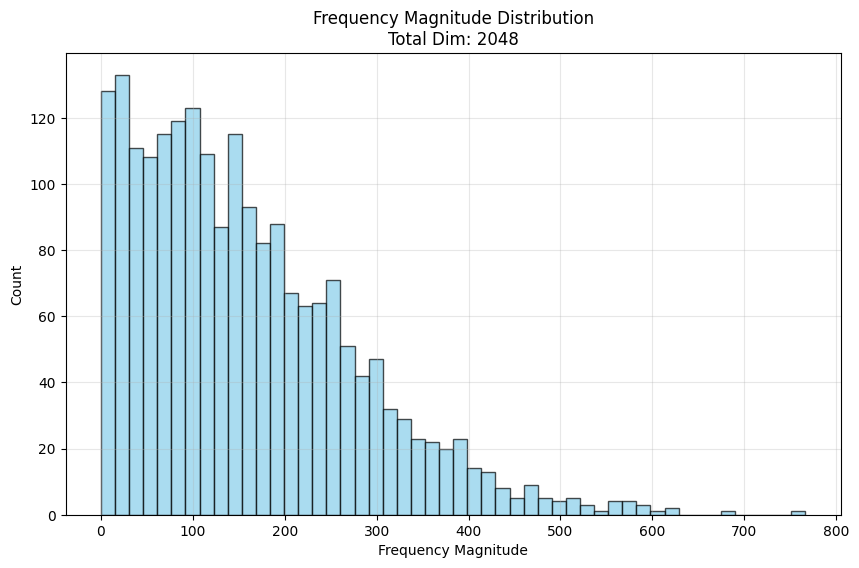

Total feature dim=2048. All Fourier feature frequencies:
[ 197.47699   175.05272   116.7572   ...  128.4127    113.406265
 -416.87555 ]


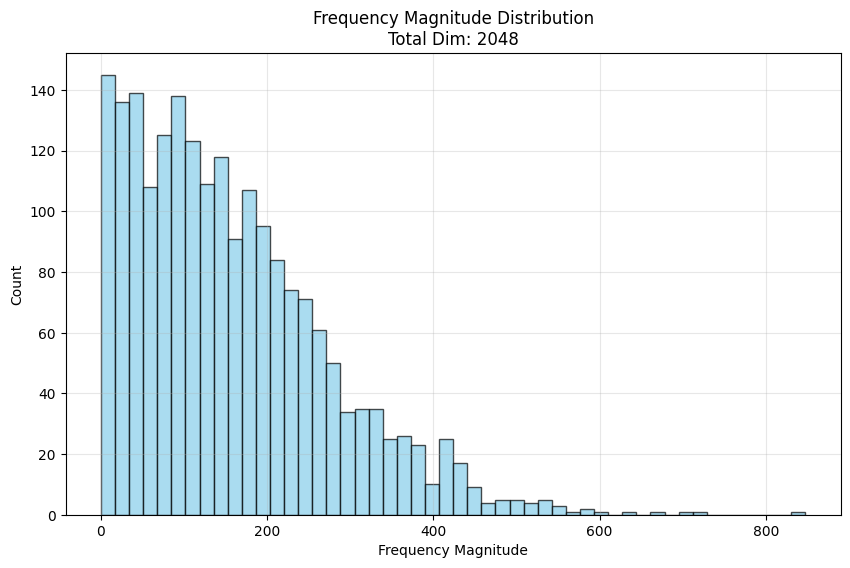

Total feature dim=2048. All Fourier feature frequencies:
[-76.134735  99.51345  -23.943584 ...  39.003017  88.467606 -42.0791  ]


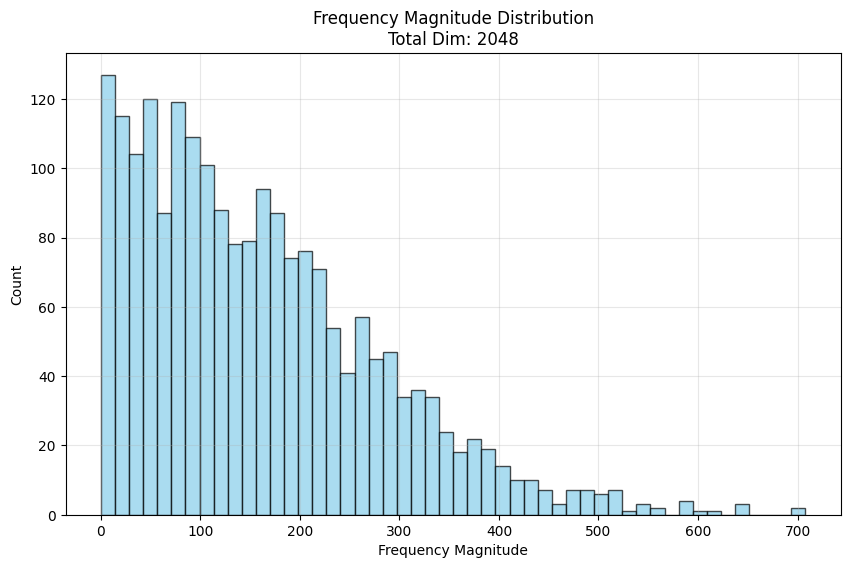

Total feature dim=2048. All Fourier feature frequencies:
[-257.42914      3.7304375   26.340801  ...   64.077065   346.9094
  -52.674652 ]


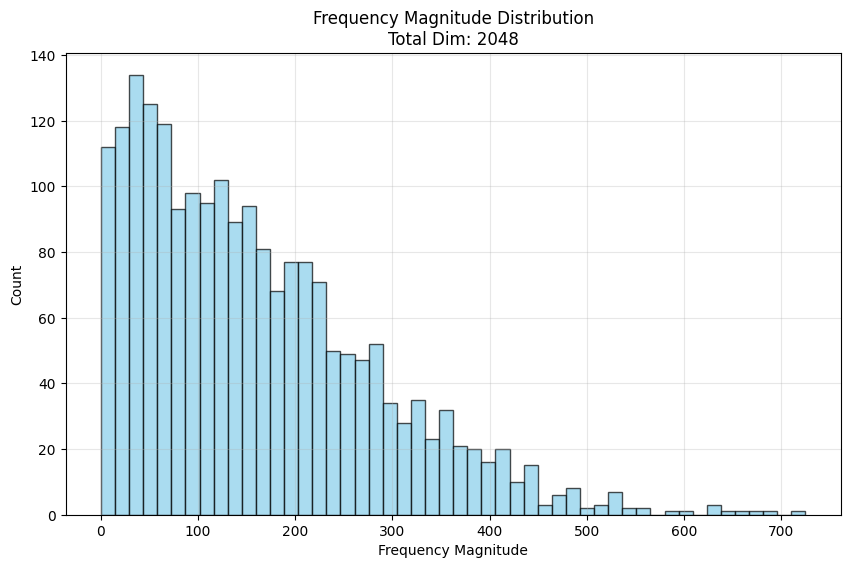

Starting training...

=== Training model with alpha=opt ===
Iter 0 |Loss_f: 5.203e+09,Loss_b:3.754e+04,Alpha: -5.425, u_h_lr: 1.000e-02, u_l_lr: 1.000e-02


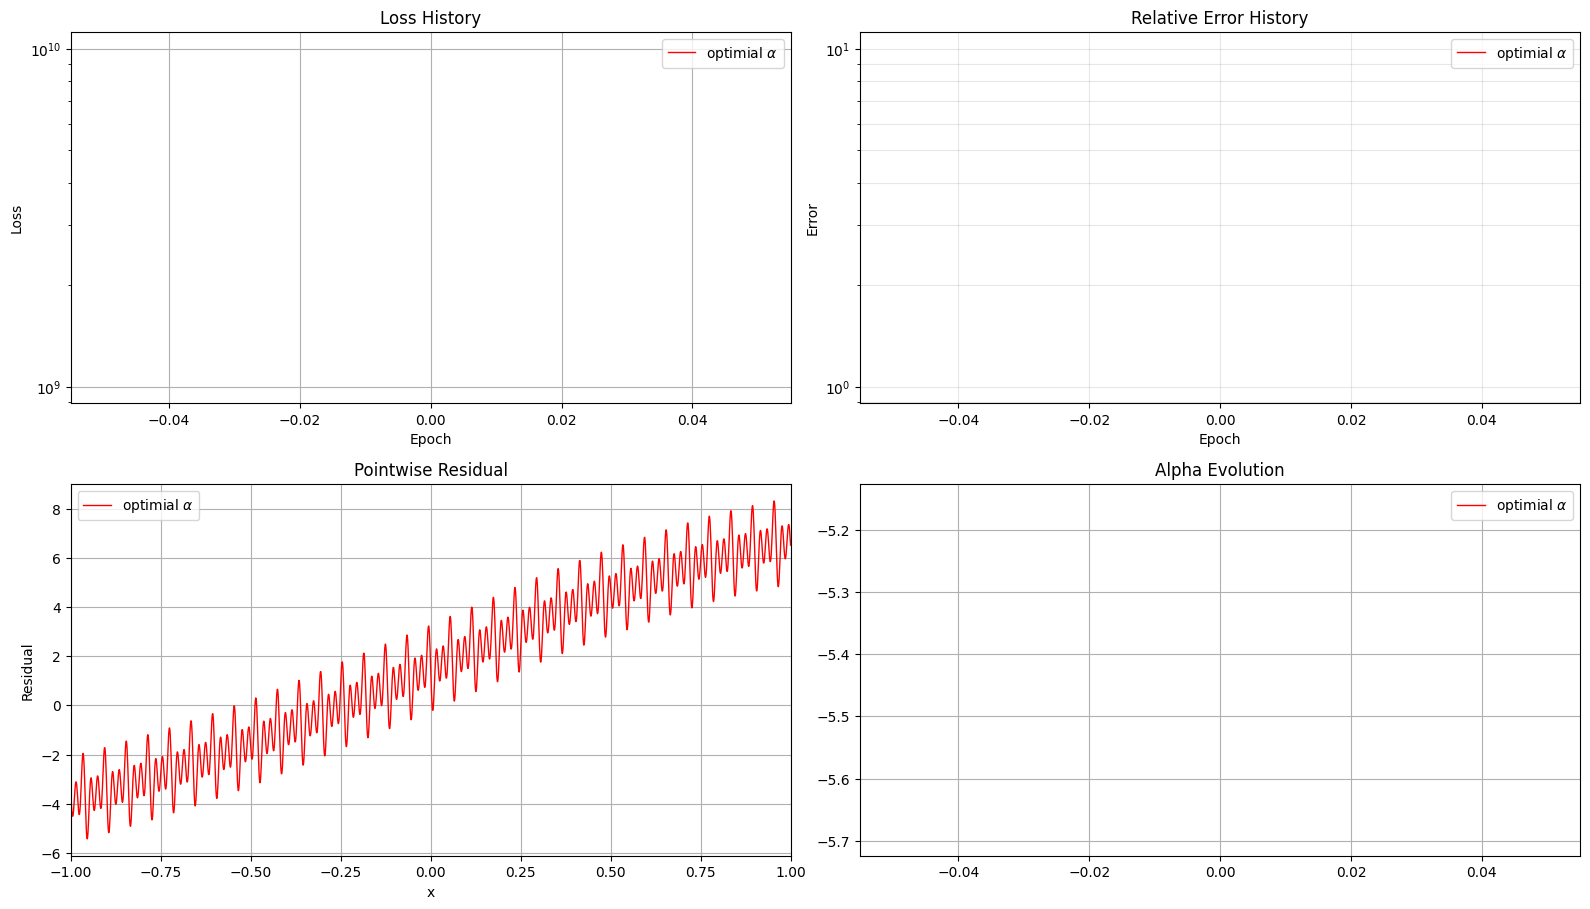

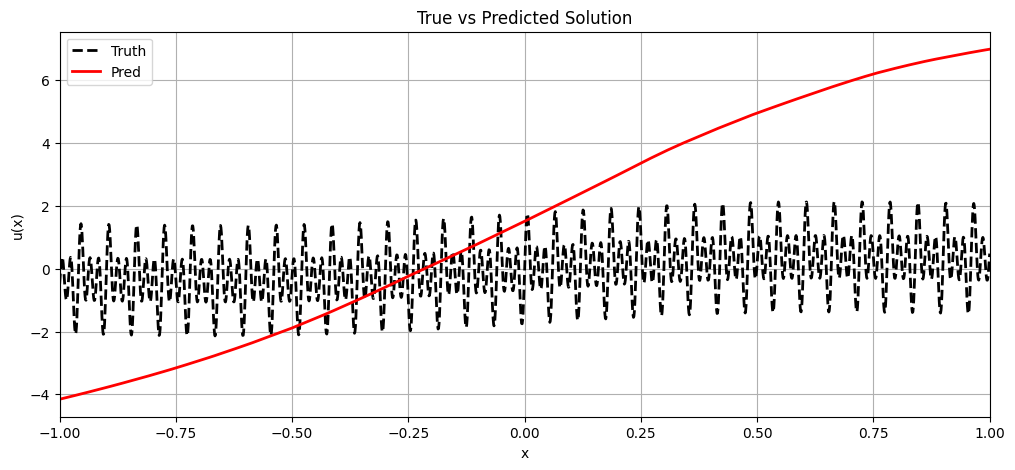

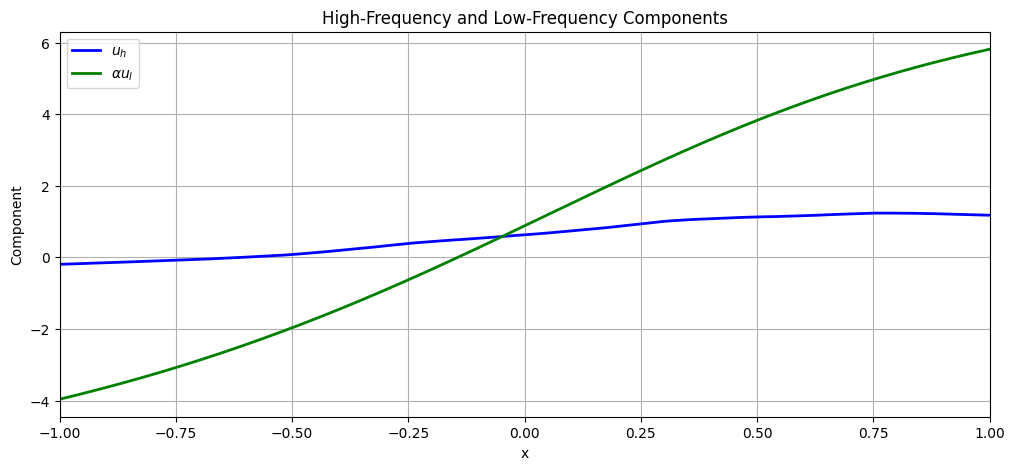


=== Training model with alpha=learnable ===
Iter 0 |Loss_f: 5.203e+09,Loss_b:6.755e+05,Alpha: -1.000, u_h_lr: 1.000e-02, u_l_lr: 1.000e-02


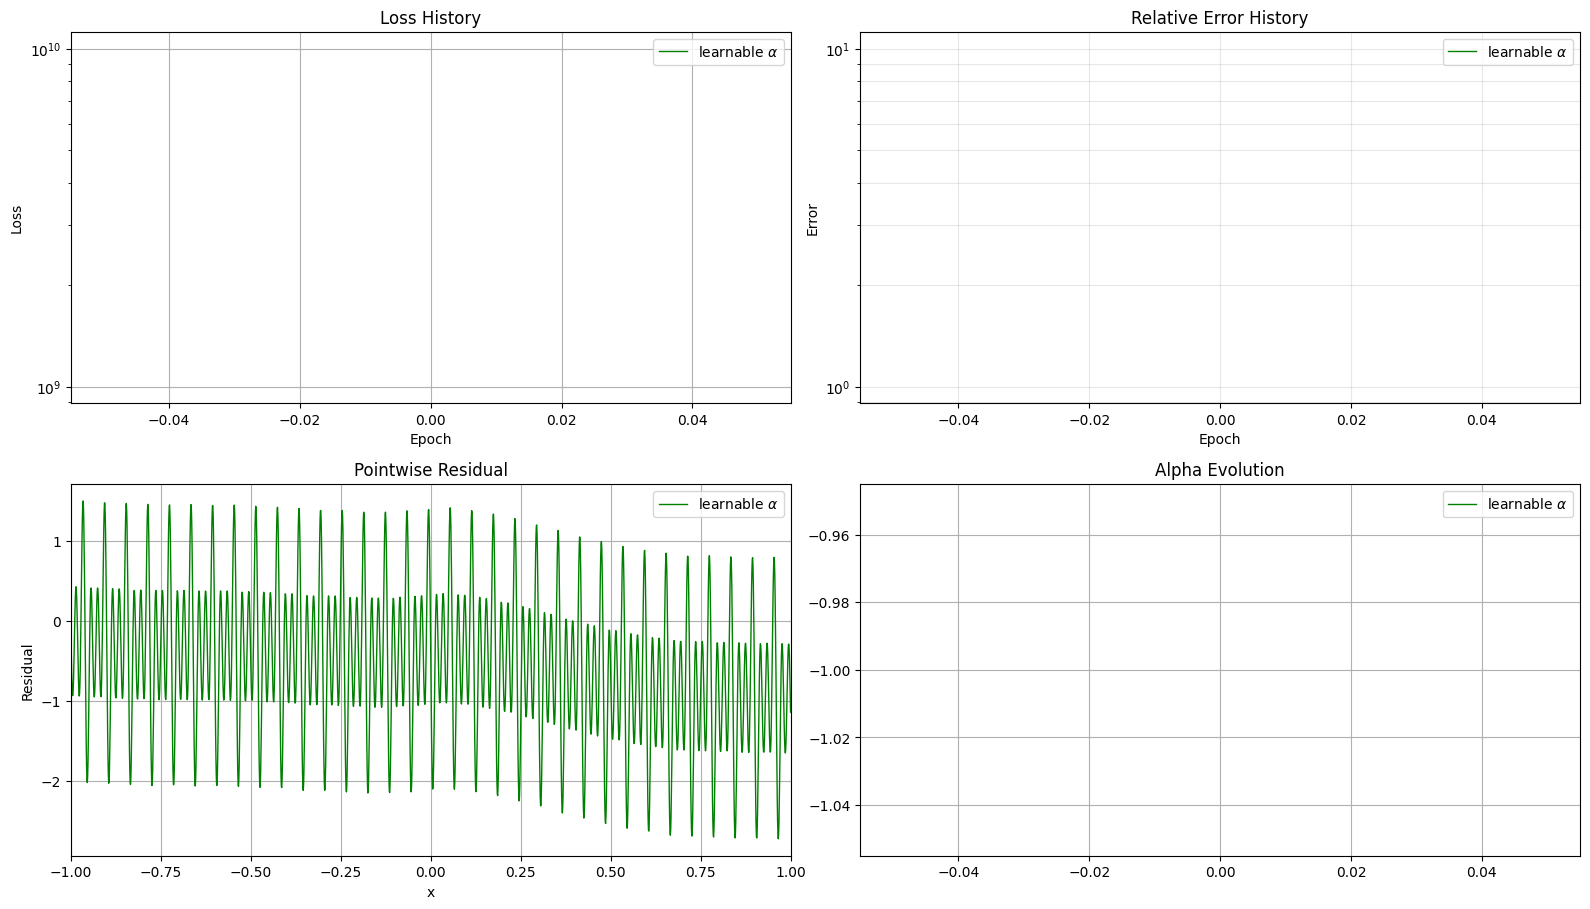

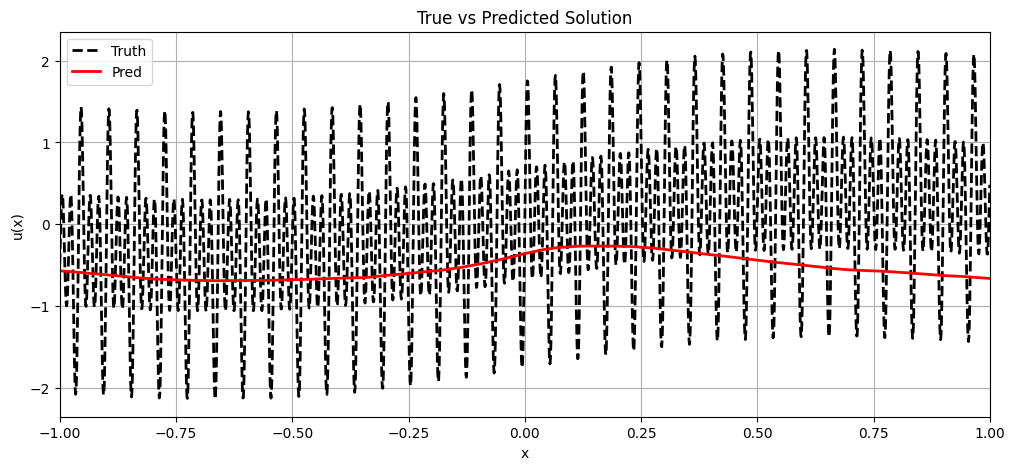

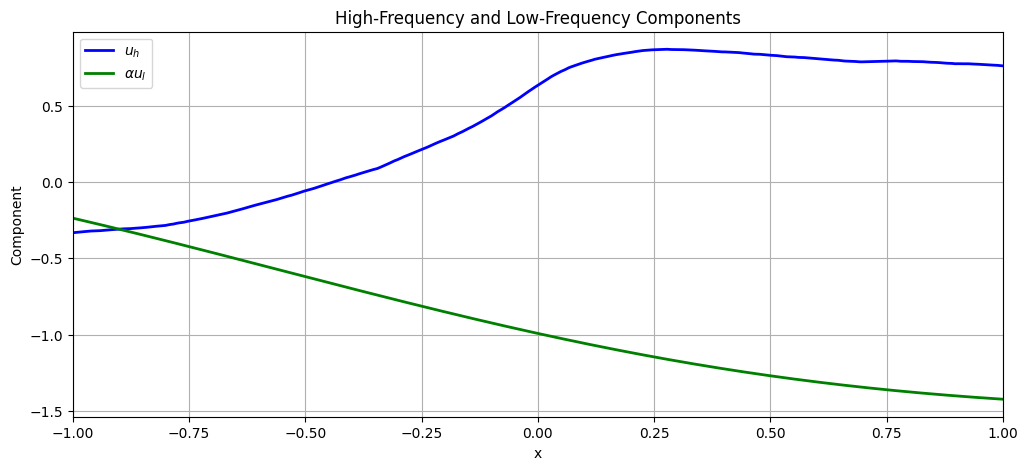


=== Training model with alpha=1 ===
Iter 0 |Loss_f: 5.203e+09,Loss_b:1.009e+06,Alpha: 1.000, u_h_lr: 1.000e-02, u_l_lr: 1.000e-02


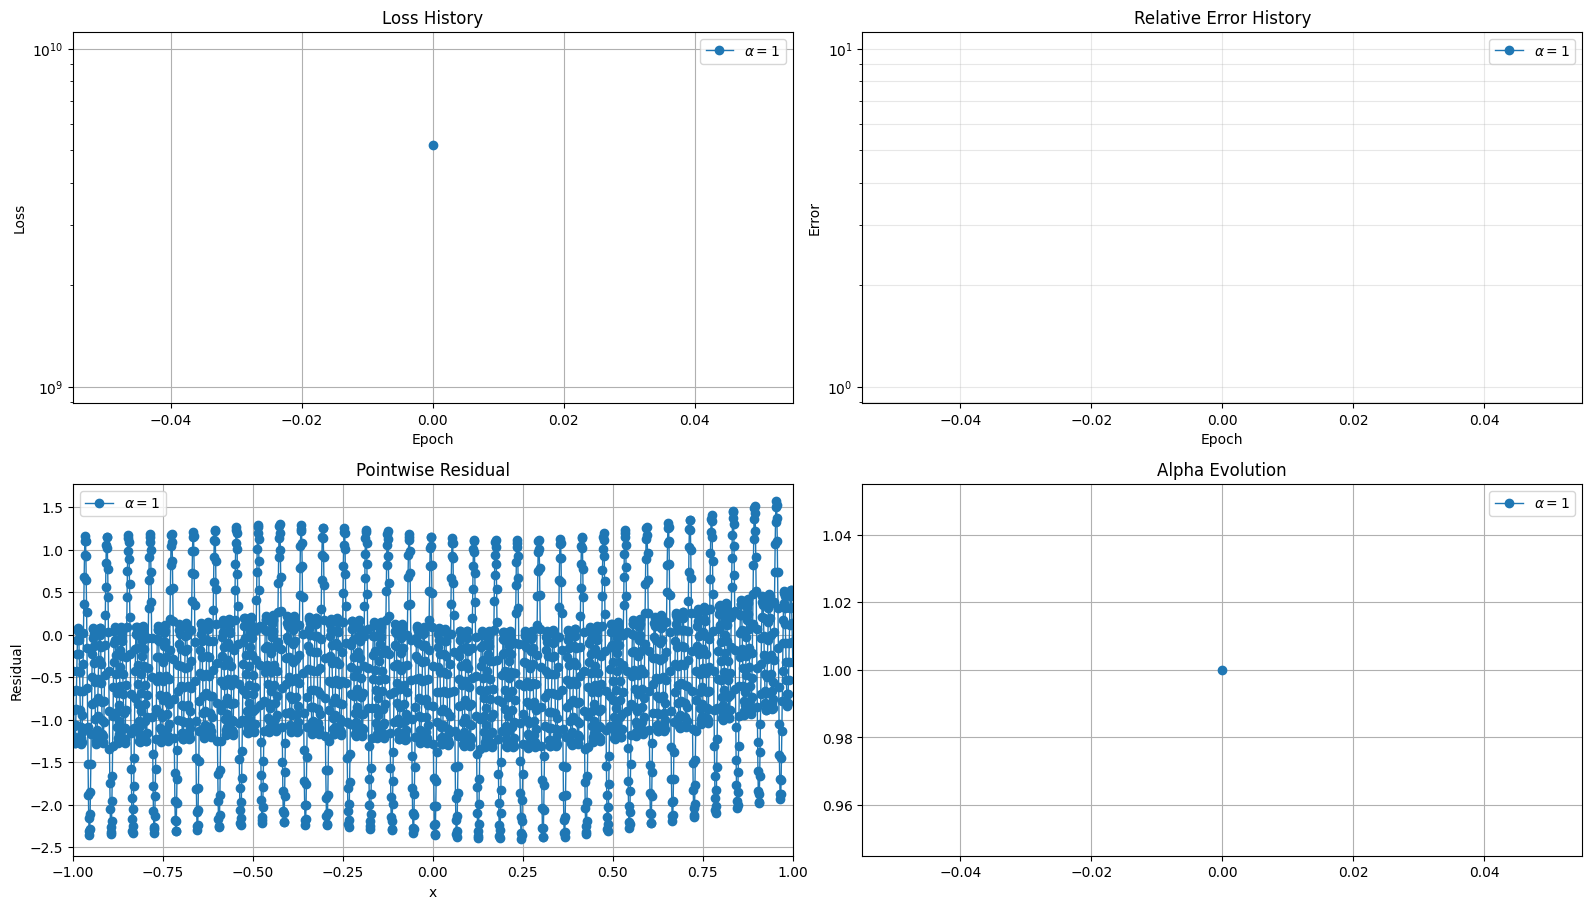

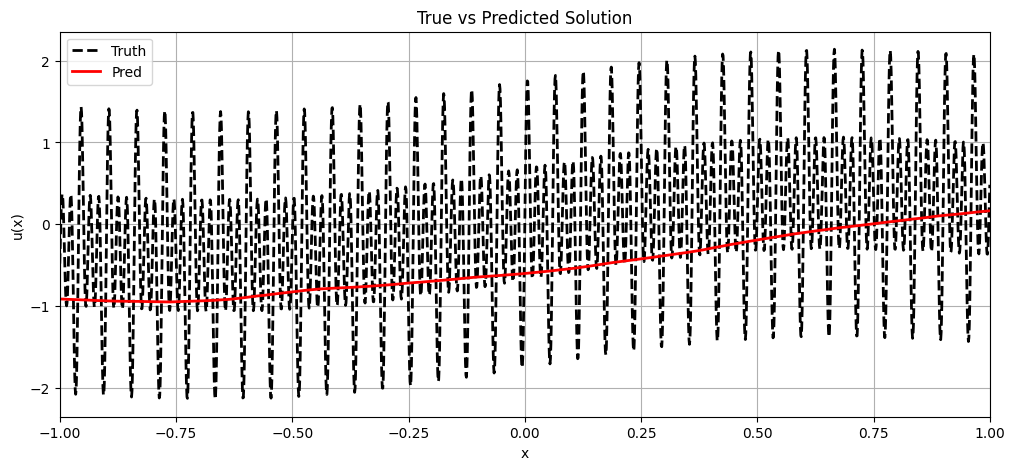

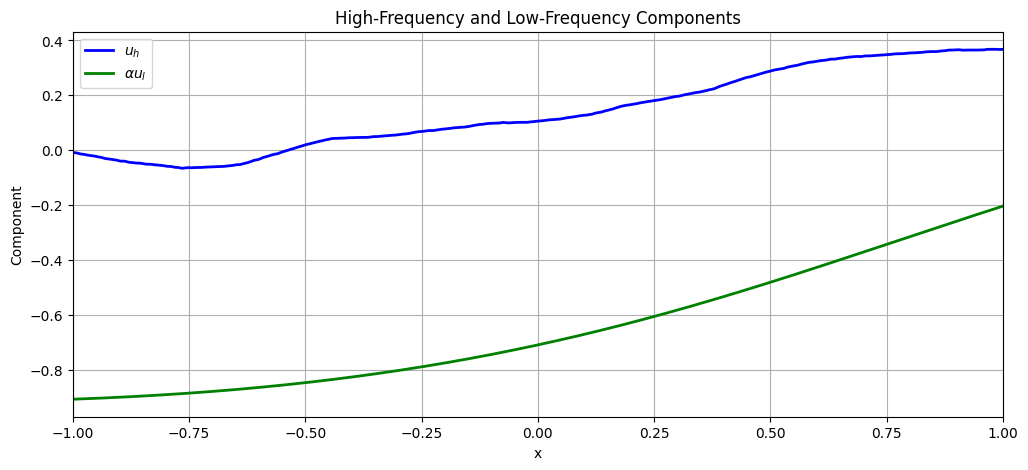


=== Training model with alpha=0 ===
Iter 0 |Loss_f: 5.202e+09,Loss_b:6.330e+05,Alpha: 0.000, u_h_lr: 1.000e-02, u_l_lr: 1.000e-02


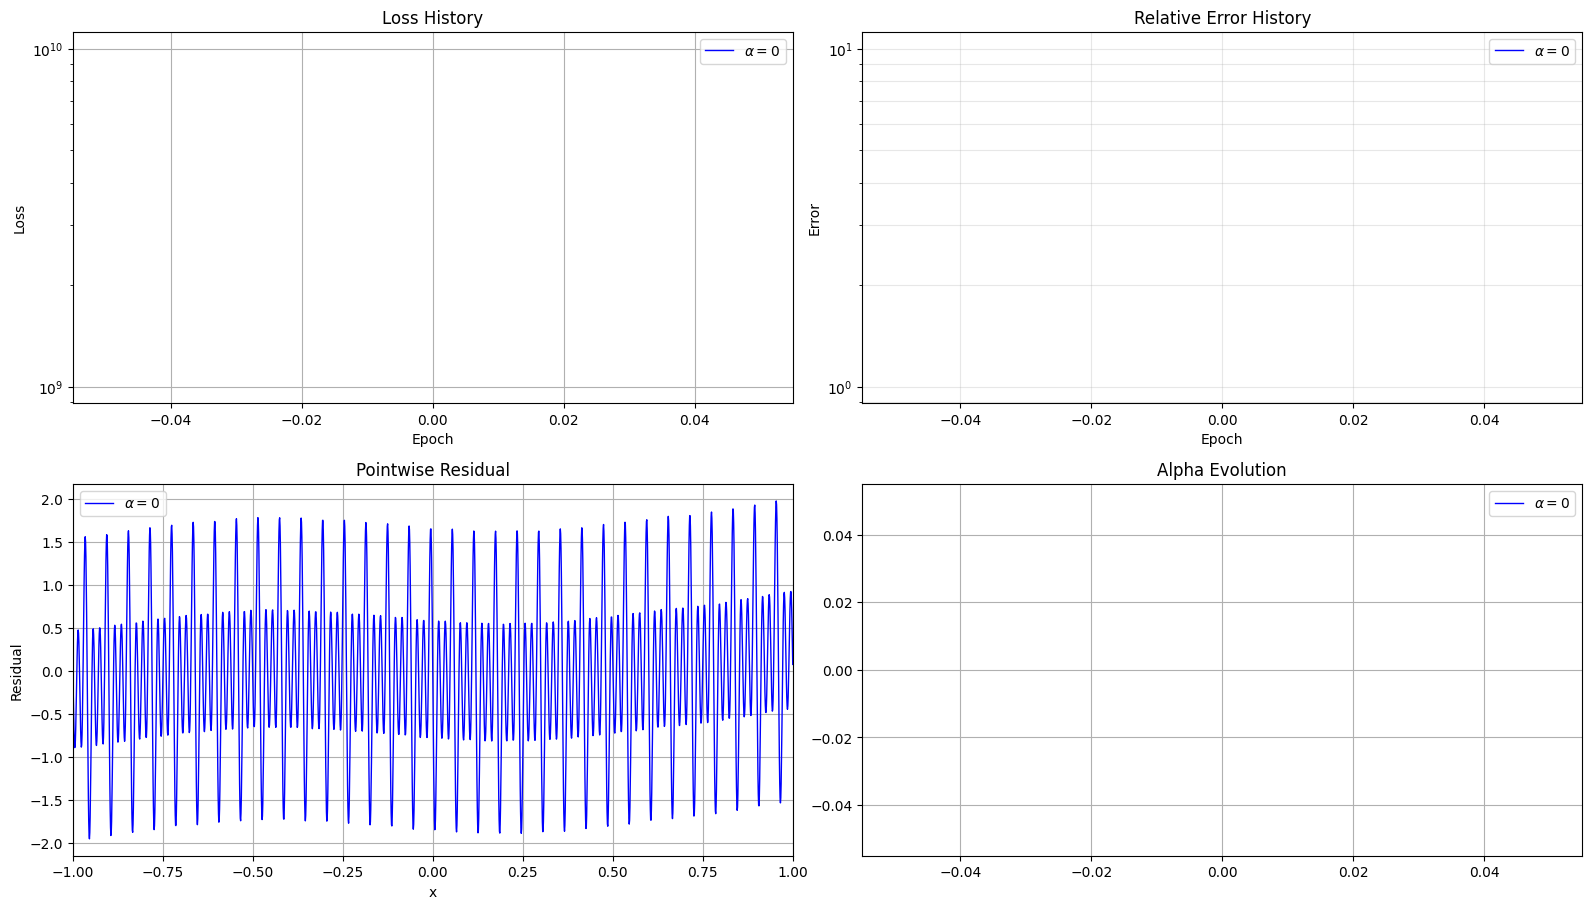

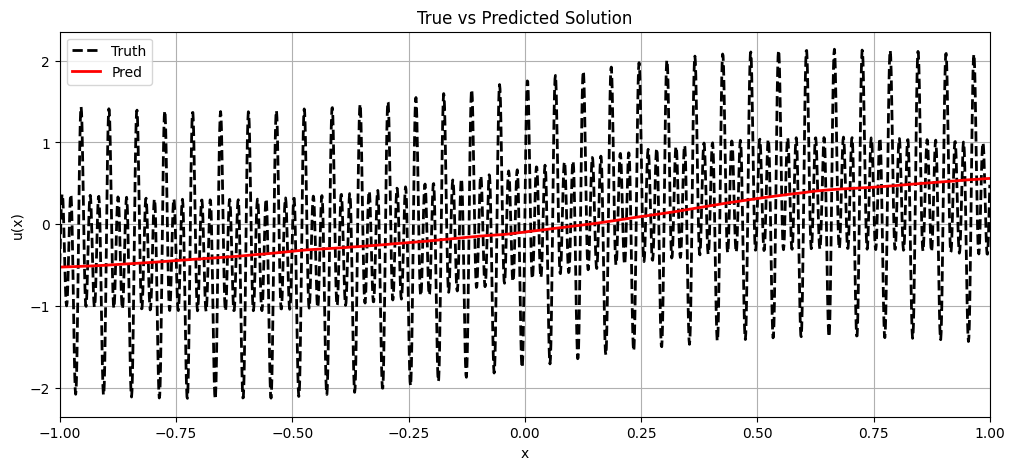

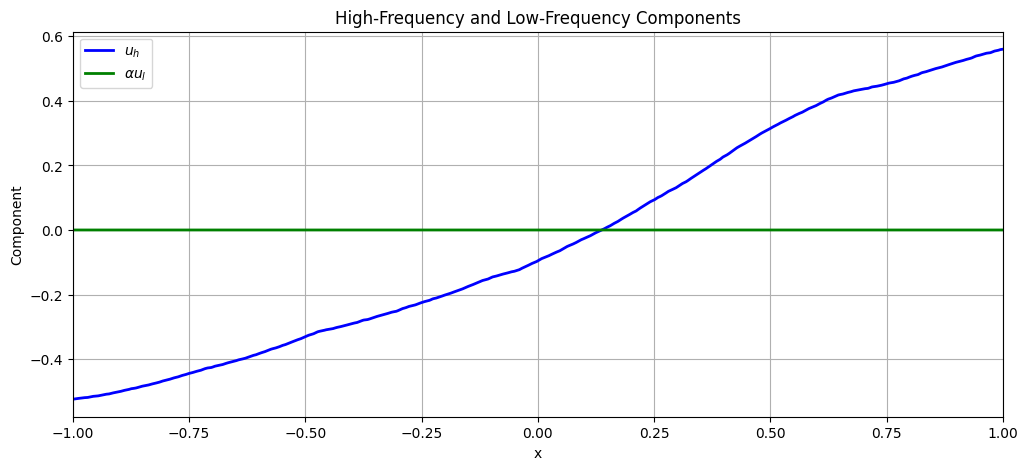

In [69]:
print("Initializing models...")
model_0 = OneDimPoissonFunc(alpha=0)
model_1 = OneDimPoissonFunc(alpha=1)
model_opt = OneDimPoissonFunc(alpha="opt")
model_learn = OneDimPoissonFunc(alpha="learnable")

models = [model_opt, model_learn, model_1, model_0]
histories = []

print("Starting training...")
for m in models:
    m.to(m.device) 
    print(f"\n=== Training model with alpha={m.alpha} ===")
    h = m.fit(1)
    histories.append(h)

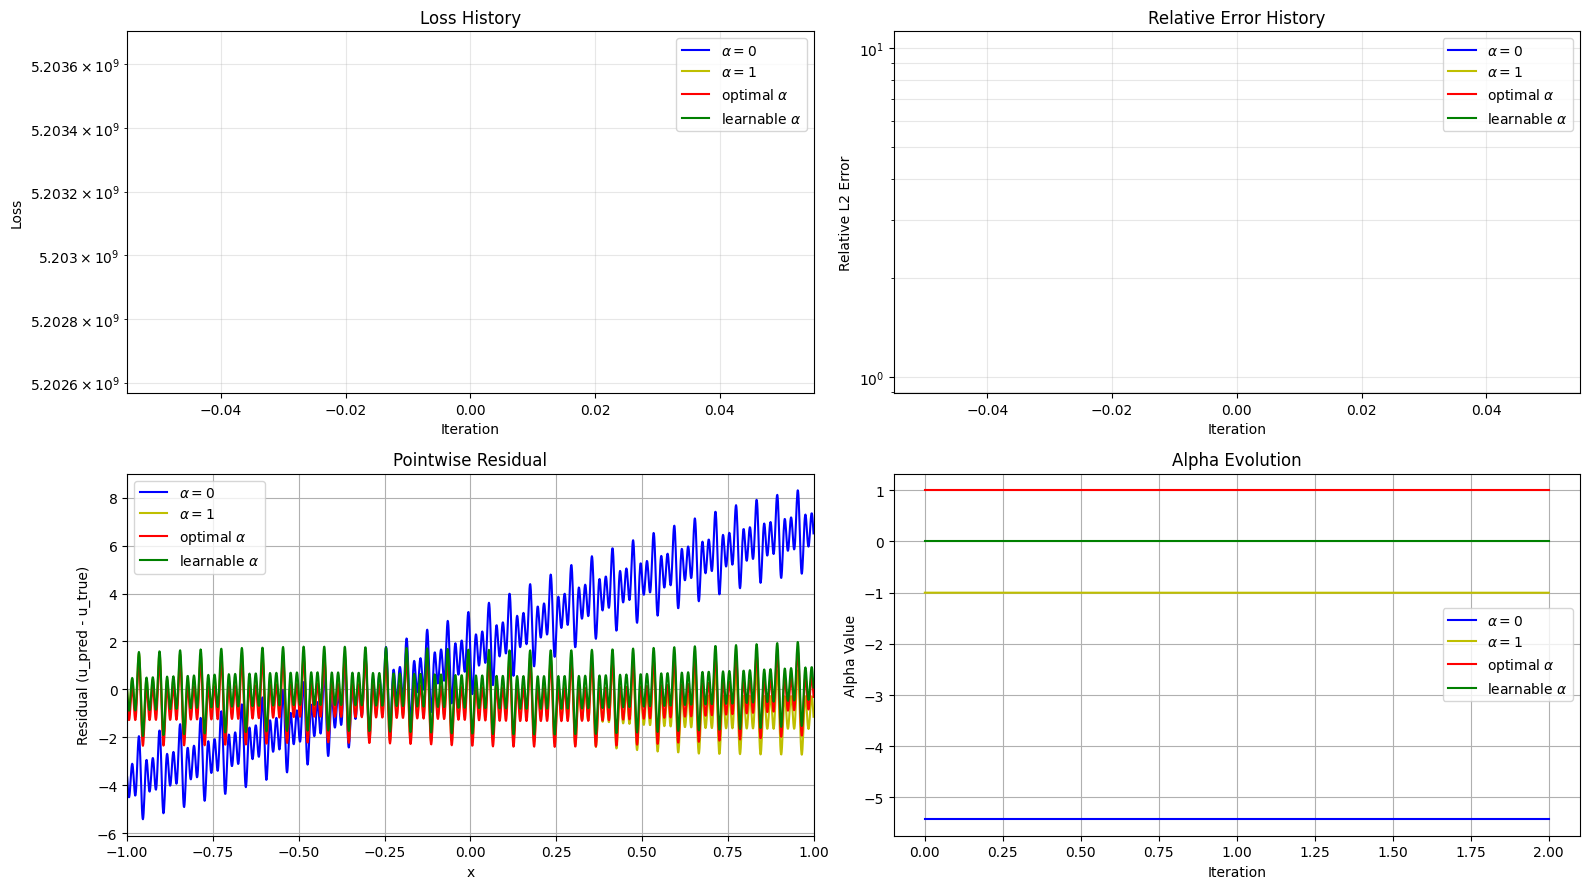

In [70]:
plot_comparison(models, histories)